In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch
from sbi.analysis import pairplot
from sbi.inference import SNPE
from sbi.utils import BoxUniform, posterior_nn
from torch import ones, zeros
import pickle

from sbi.analysis import conditional_pairplot
import pickle
import sbi
from sbi.analysis import conditional_corrcoeff
from sbi.analysis import eval_conditional_density
from helpers import *
import time
sys.path.append("../../../arco_sims/adaptive_box_posteriors/")
from  bounds import bounds_

In [3]:
xo = torch.tensor([3.1, 3.1, 3.1, 3.1, 3.1, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5])

In [17]:
filepath = "/home/michael/Documents/arco_sims/adaptive_box_posteriors2/simulations_r2/87__73418029210004229__0.005/"

In [18]:
min_ = torch.as_tensor(list(bounds_['87', '73418029210004229']["min"].values()), dtype=torch.float32)
max_ = torch.as_tensor(list(bounds_['87', '73418029210004229']["max"].values()), dtype=torch.float32)
value_ = torch.as_tensor(list(bounds_['87', '73418029210004229']["value"].values()), dtype=torch.float32)

In [19]:
limits = torch.stack([min_, max_]).T
prior = BoxUniform(min_, max_)

### Load posteriors

In [8]:
filepath = "/home/michael/Documents/arco_sims/adaptive_box_posteriors2/87_73418029210004229_0.005.pickle"
with open(filepath, "rb") as handle:
    posterior_r1 = pickle.load(handle)
    
with open("posterior_r2_87_73418_10bins_5tf_50hidden.pickle", "rb") as handle:
    posterior_r2 = pickle.load(handle)

In [10]:
posterior_r1._allow_iid_x = False

In [11]:
posterior_r1 = posterior_r1.set_default_x(xo)

In [12]:
samples_r1 = posterior_r1.sample((1000,))
samples_r2 = posterior_r2.sample((1000,))

In [51]:
names_ = load_short_names()

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


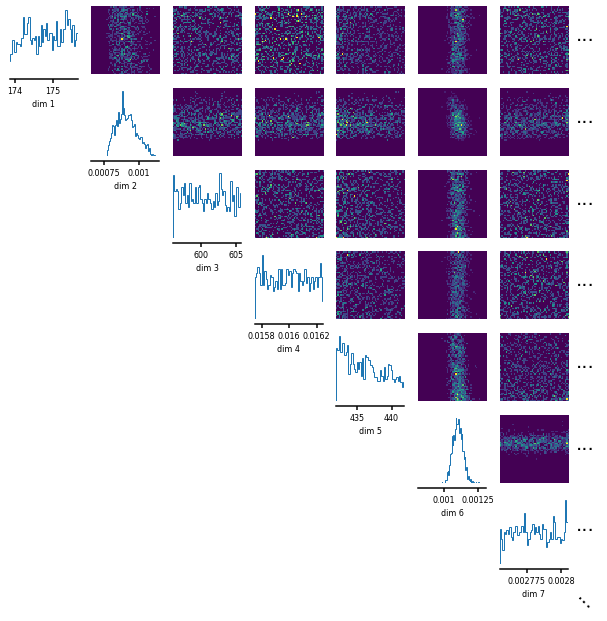

In [20]:
_ = pairplot(samples_r1, limits=limits, subset=[0, 1, 2, 3, 4, 5, 6])

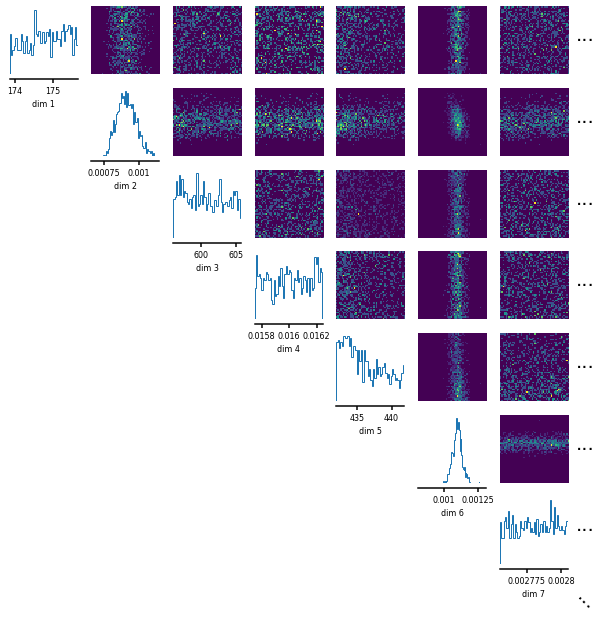

In [22]:
_ = pairplot(samples_r2, limits=limits, subset=[0, 1, 2, 3, 4, 5, 6])

### Analyse conditionals

In [31]:
samples = samples_r2
gt_ = value_

In [27]:
limits = limits.numpy()

### 1D marginals

Fraction of filled space (according to Arco's definition):   0.9497142857142857


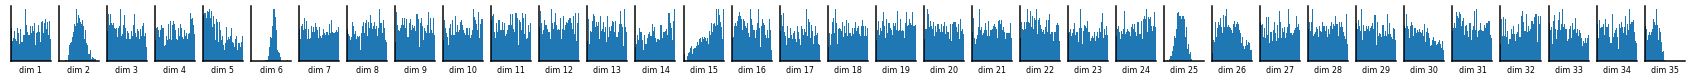

In [28]:
fraction_of_filled_space = []
fig, ax = plt.subplots(1, 35, figsize=(30, 1))
for i in range(35):
    hist_vals = ax[i].hist(samples[:, i].numpy(), bins=50, range=limits[i])
    hist_vals_bigger_zero = np.asarray(hist_vals[0]) > 0
    number_above_zero = np.sum(hist_vals_bigger_zero)
    fraction_of_filled_space.append(number_above_zero / len(hist_vals[0]))
    ax[i].set_xlim(limits[i])
    ax[i].set_yticks([])
    ax[i].set_xticks([])
    ax[i].set_xlabel(f"dim {i+1}")
print("Fraction of filled space (according to Arco's definition):  ", np.mean(fraction_of_filled_space))

In [73]:
condition = torch.as_tensor(gt_, dtype=torch.float32)

### Look at 2d conditionals

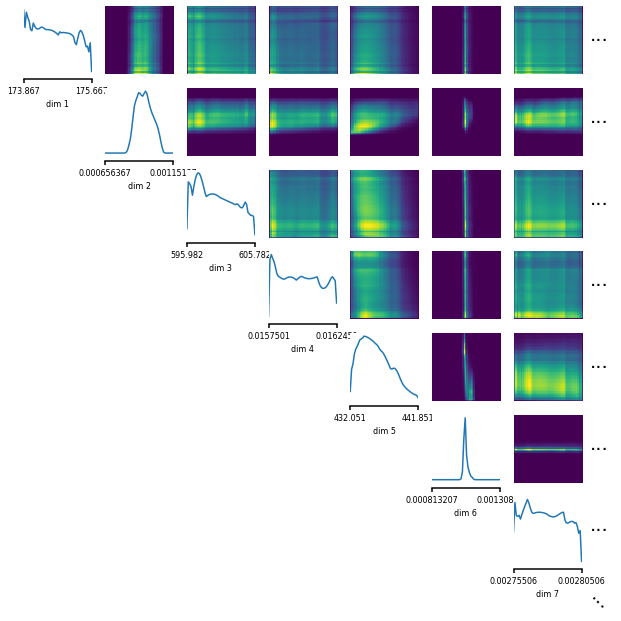

In [35]:
_ = conditional_pairplot(posterior_r2, condition=condition, subset=[0, 1, 2, 3, 4, 5, 6], limits=limits, ticks=limits, figsize=(10,10))

### Look at 2D conditionals of support

In [36]:
import sys
sys.path.append("../GA_SNPE_notebooks/")

In [50]:
from support import *
from name_helpers import *

In [40]:
support_ = PriorRejectionProposal(posterior_r2, prior, device="cpu")

../GA_SNPE_notebooks/support.py:28: UserWarning: You are using `cpu` to sample from the `PriorRejectionProposal`. This will be much slower than sampling with `cuda`.
  warn(


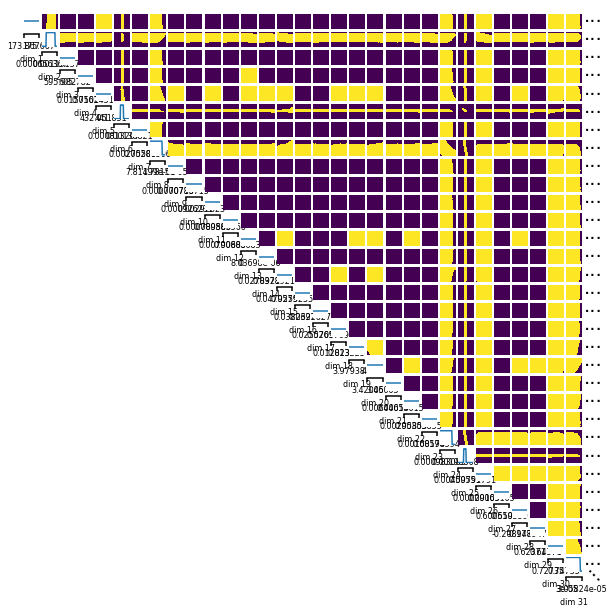

In [165]:
_ = conditional_pairplot(
    support_, 
    condition=condition, 
    subset=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], 
    limits=limits, 
    ticks=limits, 
    figsize=(10,10)
)

In [166]:
!pwd

/home/michael/Documents/lfi-experiments/bursting_biophysics/Analysis_conditionals


### Generate some validation pairs

In [146]:
import matplotlib as mpl
figuresize = 2

In [147]:
i = 5
perturbed_condition_bad = deepcopy(condition)
perturbed_condition_good = deepcopy(condition)
perturbed_condition_bad2 = deepcopy(condition)
limitsdiff = limits[i, 1] - limits[i, 0]
perturbed_condition_bad[i] = limits[i,0] + 0.1 * limitsdiff
perturbed_condition_good[i] = condition[i]
perturbed_condition_bad2[i] = limits[i,0] + 0.9 * limitsdiff

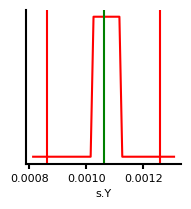

In [148]:
with mpl.rc_context(fname=".matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(figuresize,figuresize))

    i = 5
    p_vector = eval_conditional_density(
        support_,
        condition,
        limits,
        i,
        i,
        resolution=resolution,
        eps_margins1=eps_margins[i],
        eps_margins2=eps_margins[i],
        return_raw_log_prob=True
    )
    xvec = torch.linspace(limits[i,0], limits[i,1], 50)
    max_of_pvector = torch.max(p_vector)
    p_vector_exp = torch.exp(p_vector - max_of_pvector)
    ax.plot(xvec.numpy(), p_vector_exp.numpy(), c='r')
    ax.axvline(perturbed_condition_bad[i], c='r')
    ax.axvline(perturbed_condition_good[i], c='g')
    ax.axvline(perturbed_condition_bad2[i], c='r')
    ax.set_yticks([])
    ax.set_xlabel(names_[i])

In [149]:
string_pairs = ["87", "73418029210004229", "0.005"]

In [150]:
dict_holding_good_and_bad = {"morphology": [], "parameter_set": [], "good_or_bad": []}

In [151]:
dict_holding_good_and_bad["morphology"].append(string_pairs[0])
dict_holding_good_and_bad["parameter_set"].append(perturbed_condition_bad.numpy())
dict_holding_good_and_bad["good_or_bad"].append("bad")

# dict_holding_good_and_bad["morphology"].append(string_pairs[0])
# dict_holding_good_and_bad["parameter_set"].append(perturbed_condition_good.numpy())
# dict_holding_good_and_bad["good_or_bad"].append("good")

dict_holding_good_and_bad["morphology"].append(string_pairs[0])
dict_holding_good_and_bad["parameter_set"].append(perturbed_condition_bad2.numpy())
dict_holding_good_and_bad["good_or_bad"].append("bad")

In [153]:
i = 24
perturbed_condition_bad = deepcopy(condition)
perturbed_condition_good = deepcopy(condition)
perturbed_condition_bad2 = deepcopy(condition)
limitsdiff = limits[i, 1] - limits[i, 0]
perturbed_condition_bad[i] = limits[i,0] + 0.1 * limitsdiff
perturbed_condition_good[i] = condition[i]
perturbed_condition_bad2[i] = limits[i,0] + 0.9 * limitsdiff

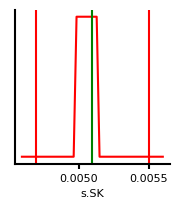

In [154]:
with mpl.rc_context(fname=".matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(figuresize,figuresize))

    p_vector = eval_conditional_density(
        support_,
        condition,
        limits,
        i,
        i,
        resolution=resolution,
        eps_margins1=eps_margins[i],
        eps_margins2=eps_margins[i],
        return_raw_log_prob=True
    )
    xvec = torch.linspace(limits[i,0], limits[i,1], 50)
    max_of_pvector = torch.max(p_vector)
    p_vector_exp = torch.exp(p_vector - max_of_pvector)
    ax.plot(xvec.numpy(), p_vector_exp.numpy(), c='r')
    ax.axvline(perturbed_condition_bad[i], c='r')
    ax.axvline(perturbed_condition_good[i], c='g')
    ax.axvline(perturbed_condition_bad2[i], c='r')
    ax.set_yticks([])
    ax.set_xlabel(names_[i])

In [155]:
dict_holding_good_and_bad["morphology"].append(string_pairs[0])
dict_holding_good_and_bad["parameter_set"].append(perturbed_condition_bad.numpy())
dict_holding_good_and_bad["good_or_bad"].append("bad")

# dict_holding_good_and_bad["morphology"].append(string_pairs[0])
# dict_holding_good_and_bad["parameter_set"].append(perturbed_condition_good.numpy())
# dict_holding_good_and_bad["good_or_bad"].append("good")

dict_holding_good_and_bad["morphology"].append(string_pairs[0])
dict_holding_good_and_bad["parameter_set"].append(perturbed_condition_bad2.numpy())
dict_holding_good_and_bad["good_or_bad"].append("bad")

In [156]:
i = 34
perturbed_condition_good1 = deepcopy(condition)
perturbed_condition_good = deepcopy(condition)
perturbed_condition_bad2 = deepcopy(condition)
limitsdiff = limits[i, 1] - limits[i, 0]
perturbed_condition_good1[i] = limits[i,0] + 0.1 * limitsdiff
perturbed_condition_good[i] = condition[i]
perturbed_condition_bad2[i] = limits[i,0] + 0.9 * limitsdiff

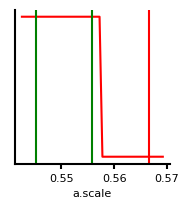

In [157]:
with mpl.rc_context(fname=".matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(figuresize,figuresize))

    p_vector = eval_conditional_density(
        support_,
        condition,
        limits,
        i,
        i,
        resolution=resolution,
        eps_margins1=eps_margins[i],
        eps_margins2=eps_margins[i],
        return_raw_log_prob=True
    )
    xvec = torch.linspace(limits[i,0], limits[i,1], 50)
    max_of_pvector = torch.max(p_vector)
    p_vector_exp = torch.exp(p_vector - max_of_pvector)
    ax.plot(xvec.numpy(), p_vector_exp.numpy(), c='r')
    ax.axvline(perturbed_condition_good1[i], c='g')
    ax.axvline(perturbed_condition_good[i], c='g')
    ax.axvline(perturbed_condition_bad2[i], c='r')
    ax.set_yticks([])
    ax.set_xlabel(names_[i])

In [158]:
dict_holding_good_and_bad["morphology"].append(string_pairs[0])
dict_holding_good_and_bad["parameter_set"].append(perturbed_condition_good1.numpy())
dict_holding_good_and_bad["good_or_bad"].append("good")

dict_holding_good_and_bad["morphology"].append(string_pairs[0])
dict_holding_good_and_bad["parameter_set"].append(perturbed_condition_bad2.numpy())
dict_holding_good_and_bad["good_or_bad"].append("bad")

In [159]:
i = 32
perturbed_condition_bad = deepcopy(condition)
perturbed_condition_good = deepcopy(condition)
limitsdiff = limits[i, 1] - limits[i, 0]
perturbed_condition_bad[i] = limits[i,0] + 0.6 * limitsdiff
perturbed_condition_good[i] = condition[i]

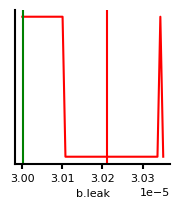

In [160]:
with mpl.rc_context(fname=".matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(figuresize,figuresize))

    p_vector = eval_conditional_density(
        support_,
        condition,
        limits,
        i,
        i,
        resolution=resolution,
        eps_margins1=eps_margins[i],
        eps_margins2=eps_margins[i],
        return_raw_log_prob=True
    )
    xvec = torch.linspace(limits[i,0], limits[i,1], 50)
    max_of_pvector = torch.max(p_vector)
    p_vector_exp = torch.exp(p_vector - max_of_pvector)
    ax.plot(xvec.numpy(), p_vector_exp.numpy(), c='r')
    ax.axvline(perturbed_condition_bad[i], c='r')
    ax.axvline(perturbed_condition_good[i], c='g')
    ax.set_yticks([])
    ax.set_xlabel(names_[i])

In [161]:
dict_holding_good_and_bad["morphology"].append(string_pairs[0])
dict_holding_good_and_bad["parameter_set"].append(perturbed_condition_bad.numpy())
dict_holding_good_and_bad["good_or_bad"].append("bad")

<ipython-input-162-2f960a3c11b6>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1, figsize=(figuresize,figuresize))


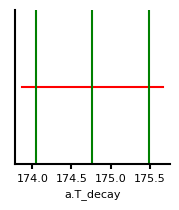

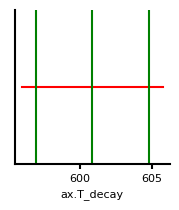

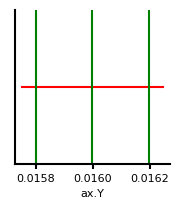

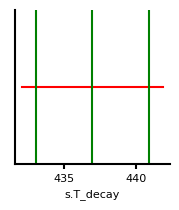

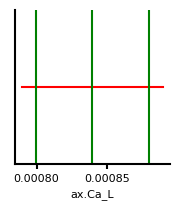

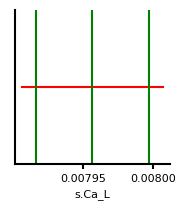

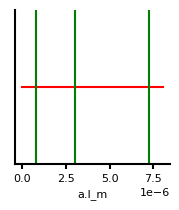

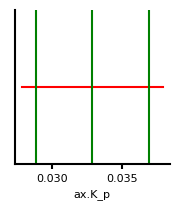

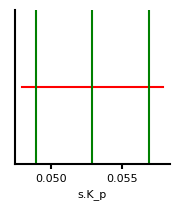

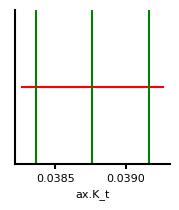

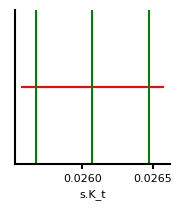

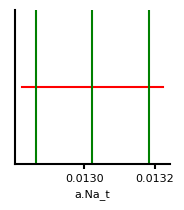

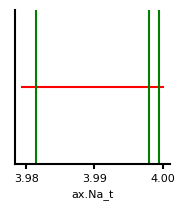

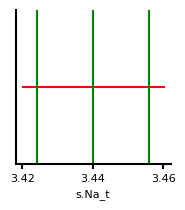

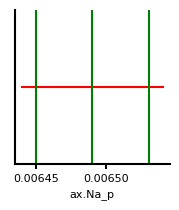

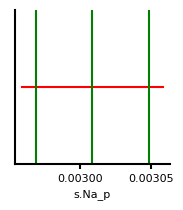

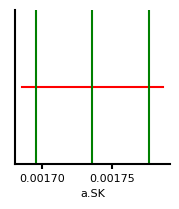

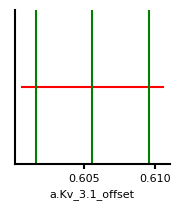

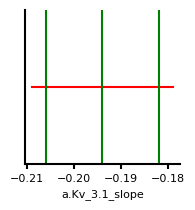

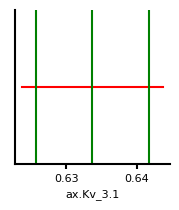

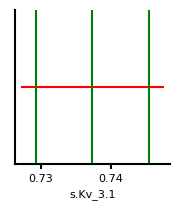

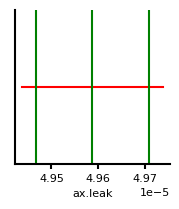

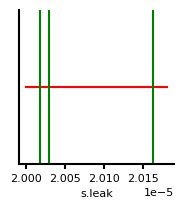

In [162]:
for i in [0, 2, 3, 4, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 26, 27, 28, 29, 31, 33]:
    perturbed_condition_good1 = deepcopy(condition)
    perturbed_condition_good = deepcopy(condition)
    perturbed_condition_good2 = deepcopy(condition)
    limitsdiff = limits[i, 1] - limits[i, 0]
    perturbed_condition_good1[i] = limits[i,0] + 0.1 * limitsdiff
    perturbed_condition_good2[i] = limits[i,0] + 0.9 * limitsdiff
    
    with mpl.rc_context(fname=".matplotlibrc"):
        fig, ax = plt.subplots(1, 1, figsize=(figuresize,figuresize))

        p_vector = eval_conditional_density(
            support_,
            condition,
            limits,
            i,
            i,
            resolution=resolution,
            eps_margins1=eps_margins[i],
            eps_margins2=eps_margins[i],
            return_raw_log_prob=True
        )
        xvec = torch.linspace(limits[i,0], limits[i,1], 50)
        max_of_pvector = torch.max(p_vector)
        p_vector_exp = torch.exp(p_vector - max_of_pvector)
        ax.plot(xvec.numpy(), p_vector_exp.numpy(), c='r')
        ax.axvline(perturbed_condition_good1[i], c='g')
        ax.axvline(perturbed_condition_good[i], c='g')
        ax.axvline(perturbed_condition_good2[i], c='g')
        ax.set_yticks([])
        ax.set_xlabel(names_[i])

    dict_holding_good_and_bad["morphology"].append(string_pairs[0])
    dict_holding_good_and_bad["parameter_set"].append(perturbed_condition_good1.numpy())
    dict_holding_good_and_bad["good_or_bad"].append("good")

    dict_holding_good_and_bad["morphology"].append(string_pairs[0])
    dict_holding_good_and_bad["parameter_set"].append(perturbed_condition_good2.numpy())
    dict_holding_good_and_bad["good_or_bad"].append("good")

In [164]:
np.save("new_dict_to_evaluate.npy", dict_holding_good_and_bad)

### Fraction of conditional

In [98]:
from sbi.analysis import eval_conditional_density
log_prob_of_condition = posterior_r2.log_prob(condition)
limits_diffs = limits[:, 1] - limits[:, 0]
eps_margins = limits_diffs / 1e5

row = 0
resolution = 50

all_log_prob_vecs = []
for row in range(35):
    p_vector = eval_conditional_density(
        support_,
        condition,
        limits,
        row,
        row,
        resolution=resolution,
        eps_margins1=eps_margins[row],
        eps_margins2=eps_margins[row],
        return_raw_log_prob=True
    )
    all_log_prob_vecs.append(p_vector)
all_log_prob_vecs = torch.stack(all_log_prob_vecs)

In [121]:
all_log_prob_vecs

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 0., 1., 0.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 0., 0., 0.]])

In [167]:
names_

['a.T_decay',
 'a.Y',
 'ax.T_decay',
 'ax.Y',
 's.T_decay',
 's.Y',
 'a.Ca_H',
 'ax.Ca_H',
 's.Ca_H',
 'a.Ca_L',
 'ax.Ca_L',
 's.Ca_L',
 'a.I_m',
 'ax.K_p',
 's.K_p',
 'ax.K_t',
 's.K_t',
 'a.Na_t',
 'ax.Na_t',
 's.Na_t',
 'ax.Na_p',
 's.Na_p',
 'a.SK',
 'ax.SK',
 's.SK',
 'a.Kv_3.1',
 'a.Kv_3.1_offset',
 'a.Kv_3.1_slope',
 'ax.Kv_3.1',
 's.Kv_3.1',
 'a.leak',
 'ax.leak',
 'b.leak',
 's.leak',
 'a.scale']

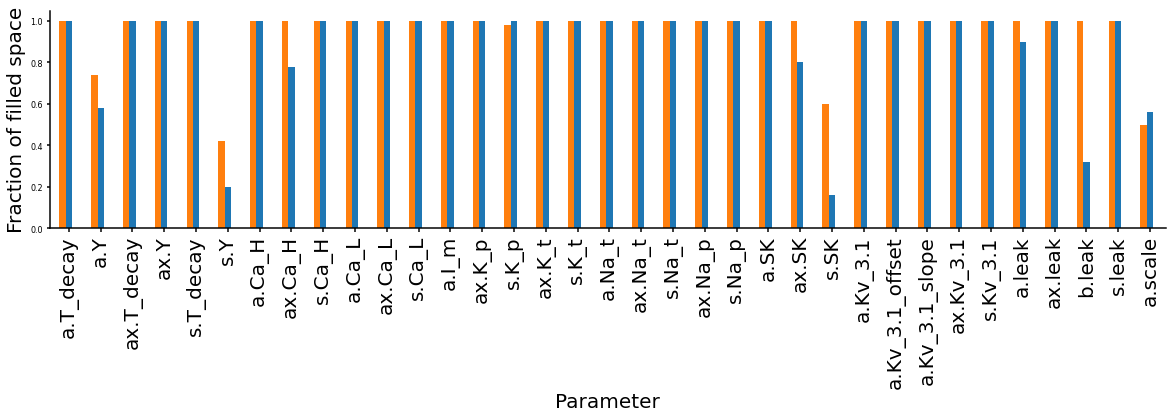

In [173]:
above_thr = all_log_prob_vecs
fractions_1d_cond = torch.sum(above_thr, axis=1) / resolution

fig, ax = plt.subplots(1,1, figsize=(20, 4))
ax.bar(np.arange(35)+1.0, fractions_1d_cond.numpy(), width=0.2)
ax.bar(np.arange(35)-0.2+1.0, fraction_of_filled_space, width=0.2)
ax.set_xlabel("Parameter", fontsize=20)
ax.set_ylabel("Fraction of filled space", fontsize=20)
ax.set_xticks(range(1, 36))
ax.set_xticklabels(names_, rotation=90, fontsize=20)
ax.set_xlim([0.4, 35.5])
plt.savefig("conditionals_of_support_87.png", dpi=200, bbox_inches="tight", facecolor='w')

In [125]:
torch.prod(fractions_1d_cond)

tensor(0.0019)

In [48]:
row = 0
resolution = 50
all_fractions_2d_cond = []

for col in range(35):
    all_log_prob_vecs = []
    for row in range(35):
        if row != col:
            p_vector = eval_conditional_density(
                posterior_r2,
                condition,
                limits,
                row,
                col,
                resolution=resolution,
                eps_margins1=eps_margins[row],
                eps_margins2=eps_margins[col],
                return_raw_log_prob=True
            )
            all_log_prob_vecs.append(p_vector)
    all_log_prob_vecs = torch.stack(all_log_prob_vecs)

    max_val = log_prob_of_condition
    all_log_prob_vecs_norm = torch.exp(all_log_prob_vecs - max_val)
    scaled_prob_of_condition = torch.exp(log_prob_of_condition - max_val)
    above_thr = all_log_prob_vecs_norm > scaled_prob_of_condition / 20.0
    any_above_thr_in_col = torch.any(above_thr, axis=2)
    fractions_2d_cond = torch.sum(any_above_thr_in_col, axis=1) / resolution
    max_rev = any_above_thr_in_col
    max_rev[max_rev == torch.max(fractions_2d_cond).item()] = float(-1e20)
    all_fractions_2d_cond.append(torch.max(max_rev).item())

(0.4, 35.5)

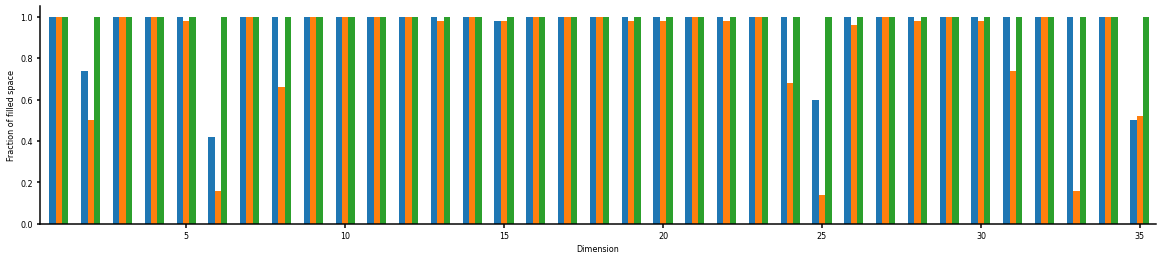

In [49]:
fig, ax = plt.subplots(1,1, figsize=(20, 4))
ax.bar(np.arange(35)-0.2+1.0, fraction_of_filled_space, width=0.2)
ax.bar(np.arange(35)+1.0, fractions_1d_cond.numpy(), width=0.2)
ax.bar(np.arange(35)+0.2+1.0, all_fractions_2d_cond, width=0.2)
ax.set_xlabel("Dimension")
ax.set_ylabel("Fraction of filled space")
ax.set_xlim([0.4, 35.5])